In [1]:
import numpy as np
import matplotlib.pyplot as plt

from n_layers_network import *

In [2]:
from sklearn.datasets import load_digits
digits = load_digits()

4

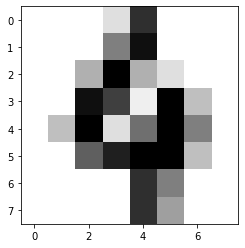

In [3]:
index = 100
plt.imshow(digits.images[index], cmap=plt.cm.gray_r)
digits.target[index]

In [4]:
from sklearn.model_selection import train_test_split
data = digits.data / 16
train_X, test_X, train_y, test_y = train_test_split(data, digits.target, test_size=0.1, random_state=1)


import numpy as np
train_y_ohe = np.zeros((10, train_y.shape[0]))
for count, y in enumerate(train_y):
    train_y_ohe[y][count] = 1

# take the transpose
train_X = train_X.T
test_X = test_X.T

In [5]:
train_X.shape, train_y_ohe.shape

((64, 1617), (10, 1617))

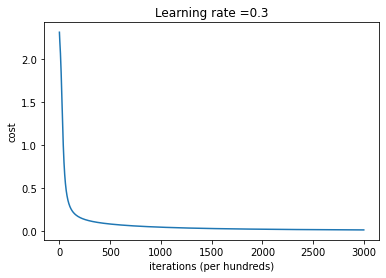

In [6]:
layers_dimensions = [64, 20, 10]
lr = 0.3
num_iter = 3000

# without regularization and dropout
parameters = L_layer_model(train_X, train_y_ohe, layers_dimensions, learning_rate=lr, num_iterations=num_iter)

In [7]:
def model(X, Y, layers_dimensions, learning_rate=0.1, num_iterations=2000, print_cost=False, lambd=0, keep_prob=1): 

    grads = {}
    costs = []

    # initialize model
    parameters = initialize_parameters(layers_dimensions)   

    # gradient descent
    for i in range(0, num_iterations):

        # forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID

        if keep_prob == 1:
            AL, caches = forward_propagation(X, parameters)
        elif keep_prob < 1: 
            AL, caches = forward_propagation_with_dropout(X, parameters, keep_prob)

        # compute cost
        if lambd == 0: 
            cost = compute_cost(AL, Y)
        else: 
            cost = compute_cost_with_regularization(AL, Y, parameters, lambd)

        # backward propatation
        assert(lambd==0 or keep_prob==1)

        if lambd == 0 and keep_prob == 1: 
            grads = backward_propagation(AL, Y, caches)
        elif lambd != 0:
            grads = backward_propagation_with_regularization(AL, Y, caches, lambd)
        elif keep_prob < 1: 
            grads = backward_propagation_with_dropout(AL, Y, caches, keep_prob)

        # updata parameters
        parameters = update_parameters(parameters, grads, learning_rate)

        # print and save cost value
        if print_cost and i % 100 == 0: 
            print ("Cost after iteration %i: %f" %(i, cost))
        costs.append(cost)

    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    return parameters

In [8]:
def compute_cost_with_regularization(AL, Y, parameters, lambd):

    m = Y.shape[1]
    L = len(parameters) // 2

    cross_entropy_cost = compute_cost(AL, Y)

    L2_regularization_cost = 0
    for i in range(1, L + 1): 
        W = parameters['W' + str(i)]
        L2_regularization_cost += np.sum(np.square(W))
    L2_regularization_cost *= 1/m * lambd/2

    cost = cross_entropy_cost + L2_regularization_cost

    return cost

In [9]:
def linear_backward_with_regularization(dZ, cache, lambd):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    # add the regularization term's gradient
    dW = 1/m * np.dot(dZ, A_prev.T) + lambd/m * W
    db = 1/m * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    return dA_prev, dW, db

def backward_propagation_with_regularization(AL, Y, caches, lambd): 

    grads = {}
    L = len(caches) 

    dZL = AL - Y
    linear_cache, ZL = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_backward_with_regularization(dZL, linear_cache, lambd)

    for l in reversed(range(1, L)):
        linear_cache, Z = caches[l-1]
        dZ = relu_activation_backward(grads["dA" + str(l)], Z)
        grads["dA" + str(l-1)], grads["dW" + str(l)], grads["db" + str(l)] = linear_backward_with_regularization(dZ, linear_cache, lambd)

    return grads

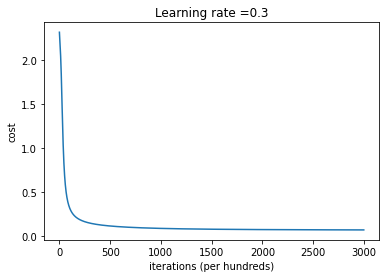

In [10]:
parameters_L2 = model(train_X, train_y_ohe, layers_dimensions, learning_rate=lr, num_iterations=num_iter, lambd = 0.7)

In [11]:
def forward_propagation_with_dropout(X, parameters, keep_prob = 0.5): 
    """ (LINEAR -> RELU) * (L-1) -> LINEAR -> SOFTMAX """ 

    L = len(parameters) // 2
    caches = [] 
    A = X 
    for l in range(1, L): 
        A_prev = A
        Z, linear_cache = linear_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)])
        A = relu_activation(Z)

        # dropout
        D = np.random.rand(A.shape[0], A.shape[1])
        D = (D < keep_prob).astype(int)
        A = A * D
        
        cache = (linear_cache, Z, D)
        caches.append(cache)

    ZL, linear_cache = linear_forward(A, parameters['W' + str(L)], parameters['b' + str(L)])
    AL = softmax_activation(ZL)
    cache = (linear_cache, ZL)
    caches.append(cache)

    return AL, caches

def backward_propagation_with_dropout(AL, Y, caches, keep_prob): 

    grads = {}
    L = len(caches) 

    dZL = AL - Y
    linear_cache, ZL = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_backward(dZL, linear_cache)

    for l in reversed(range(1, L)):
        linear_cache, Z, D = caches[l-1]
        dA = grads["dA" + str(l)]
        # shat down neruons
        dA = dA * D
        # scale value 
        dA = dA / keep_prob

        dZ = relu_activation_backward(dA, Z)
        grads["dA" + str(l-1)], grads["dW" + str(l)], grads["db" + str(l)] = linear_backward(dZ, linear_cache)
        
    return grads

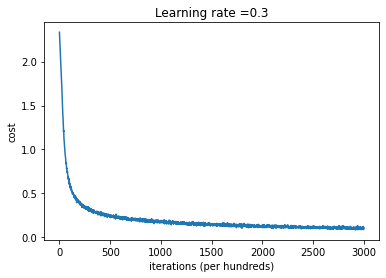

In [12]:
parameters_dropout = model(train_X, train_y_ohe, layers_dimensions ,learning_rate=lr, num_iterations=num_iter, keep_prob = 0.8)

In [13]:
from sklearn.metrics import accuracy_score
y_hat = predict(test_X, parameters)
y_hat_L2 = predict(test_X, parameters_L2)
y_hat_dropout = predict(test_X, parameters_dropout)
print("no regularization:", accuracy_score(test_y, y_hat))
print("L2 regularization:", accuracy_score(test_y, y_hat_L2))
print("dropout:", accuracy_score(test_y, y_hat_dropout))

no regularization: 0.9722222222222222
L2 regularization: 0.9777777777777777
dropout: 0.9833333333333333
